# Perceptions&Interactions TP3 - Traitement d'image, Partie 2

## Introduction

*Imports et chargement d'image*

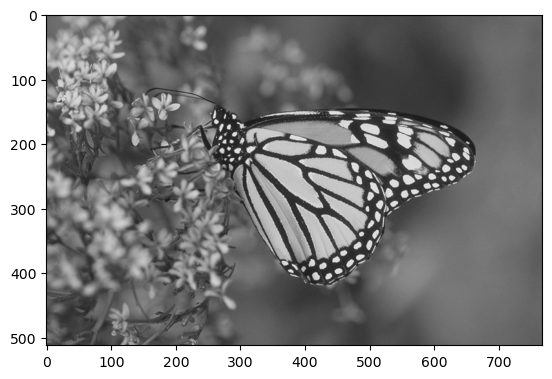

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("butterfly_gray.png")
plt.imshow(img)
plt.show()

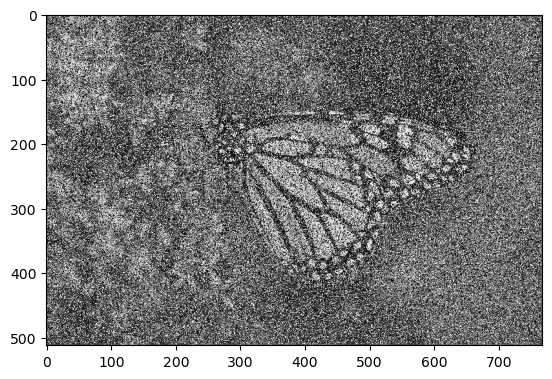

In [68]:
def add_salt_and_pepper_noise(image, salt_prob, pepper_prob):
    noisy_image = np.copy(image)
    total_pixels = image.size

    # Ajoutez du bruit "sel" (valeurs maximales) aux pixels
    num_salt = int(total_pixels * salt_prob)
    salt_coords = [np.random.randint(0, i - 1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1]] = 255

    # Ajoutez du bruit "poivre" (valeurs minimales) aux pixels
    num_pepper = int(total_pixels * pepper_prob)
    pepper_coords = [np.random.randint(0, i - 1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1]] = 0

    return noisy_image


noise = add_salt_and_pepper_noise(img, 0.10, 0.10)

plt.imshow(noise)

### **0. Filtre médian**

Codez la fonction filtre_median(img, half_size).

Cette fonction renvoie une nouvelle image dans laquelle chaque pixel (x,y) équivaut à la valeur médiane parmi les pixels voisins. Le voisinage considéré pourra être un carré allant de (x-half_size, y-half_size) à (x+half_size, y+half_size), c'est-à-dire un carré centré en (x-y) de taille size=(2\*half_size)+1.

On considèrera que les 3 canaux sont identiques (image en niveau de gris sur 3 canaux).

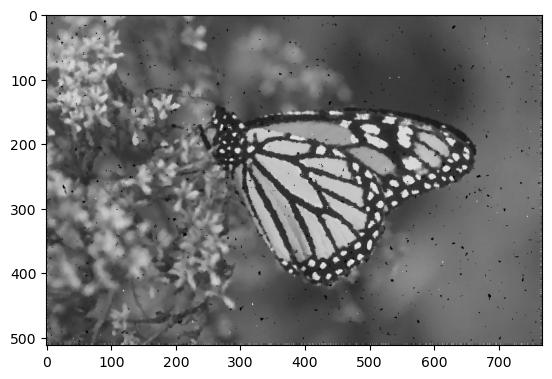

In [77]:
def median(img, half_size):
    img = img.astype('float32')
    result = img.copy()
    for i in range(half_size, img.shape[0] - half_size):
        for j in range(half_size, img.shape[1] - half_size):
            #On effectue un "slicing" sur notre image ce qui va faire un équivalent de "for" mais en plus rapide
            #on effectue un traitement supplémentaire au centre du tableau, car sinon de base on prends
            #deux fois le pixel central hors on ne le veut que une fois
            neighborhood = img[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1].flatten()
            neighborhood = np.delete(neighborhood, len(neighborhood) // 2)
            result[i, j] = np.median(neighborhood)
    return result.astype('uint8')

plt.imshow(median(noise,2))

### **1. Erosion**

Codez la fonction erosion(img, half_size).

Cette fonction renvoie une nouvelle image dans laquelle chaque pixel (x,y) équivaut à la valeur la plus **faible** parmi les pixels voisins. Le voisinage considéré pourra être un carré allant de (x-half_size, y-half_size) à (x+half_size, y+half_size), c'est-à-dire un carré centré en (x-y) de taille size=(2\*half_size)+1.

On considèrera que les 3 canaux sont identiques (image en niveau de gris sur 3 canaux).

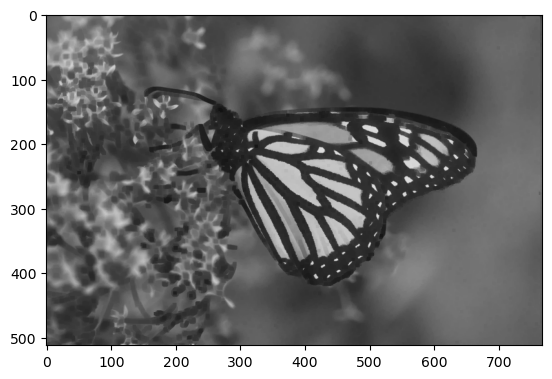

In [70]:
def erosion(img, half_size):
    result = img.copy()
    img = img.astype('float32')
    for i in range(half_size, img.shape[0] - half_size):
        for j in range(half_size, img.shape[1] - half_size):
            #Comme pour la médiane on fait aussi ici  un slicing pour prendre un voisinage en croix
            neighborhood = img[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1].flatten()
            neighborhood = np.delete(neighborhood, len(neighborhood) // 2)
            result[i, j] = np.min(neighborhood)
    return result.astype('uint8')

img_erodee = erosion(img, 2)
plt.imshow(img_erodee)

### **2. Dilatation**

Codez la fonction dilation(img, half_size).

Cette fonction, à l'instar de la fonction erosion, renvoie une nouvelle image dans laquelle chaque pixel (x,y) équivaut à la valeur la plus **élevée** parmi les pixels voisins.

On considèrera à nouveau que les 3 canaux sont identiques (image en niveau de gris sur 3 canaux).

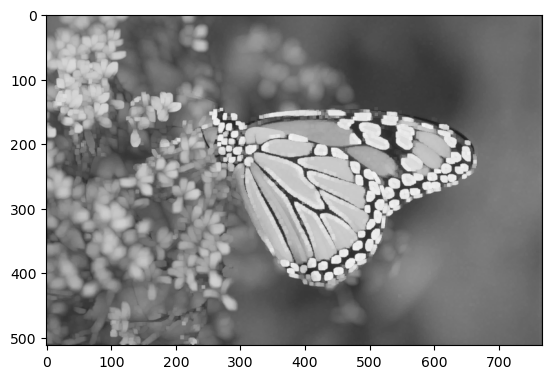

In [71]:
def dilation(img, half_size):
    result = img.copy()
    img = img.astype('float32')
    for i in range(half_size, img.shape[0] - half_size):
        for j in range(half_size, img.shape[1] - half_size):
            #De la même manière que pour l'érosion on fait un slicing identique
            neighborhood = img[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1].flatten()
            neighborhood = np.delete(neighborhood, len(neighborhood) // 2)
            result[i, j] = np.max(neighborhood)
    return result.astype('uint8')


img_dilatee = dilation(img, 2)
plt.imshow(img_dilatee)

### 3. Extraction de contours avec dilation et erosion

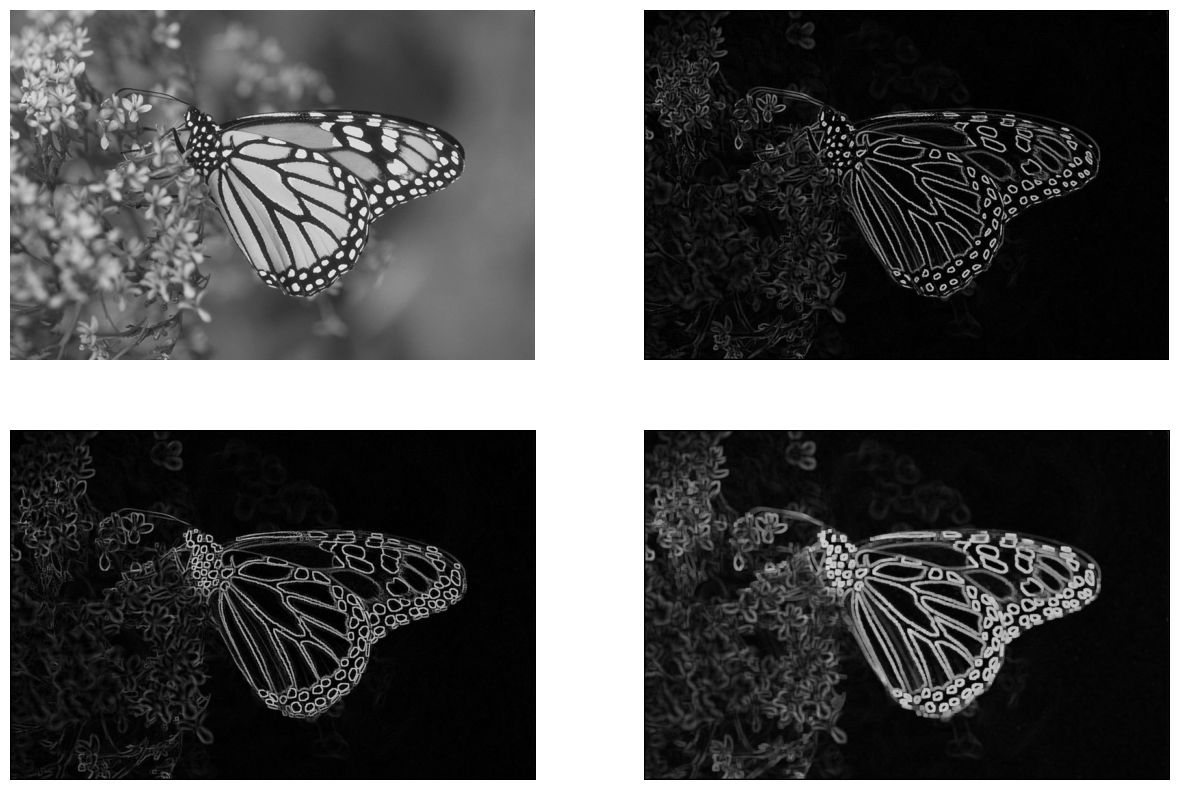

In [72]:
g1 = img - img_erodee #gradient interne, pixels retirés par l'érosion = contours intérieurs
g2 = img_dilatee - img #gradient externe, pixels ajoutés par la dilatation = contours extérieurs
g3 = img_dilatee - img_erodee #gradient morphologique, combinaison des deux approches = tous les contours


fig, ax = plt.subplots(2,2, figsize=(15,10))
ax[0,0].imshow(img)
ax[0,1].imshow(g1)
ax[1,0].imshow(g2)
ax[1,1].imshow(g3)
[ax[x,y].axis("off") for x in range(2) for y in range(2)];


### 4. Features from Accelerated Segment Test (FAST)

FAST est un algorithme de détection de points d'intérêt. Pour chaque pixel, un cercle de rayon 3 des pixels "voisins" est calculé. Tout d'abord, on choisit de définir un cercle tel que :

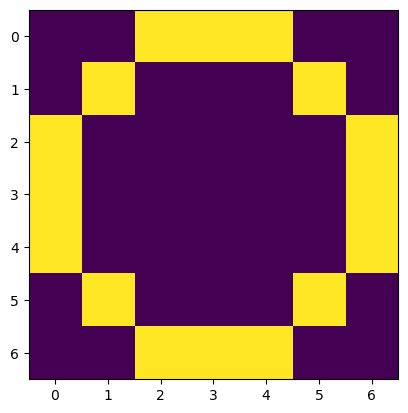

In [73]:
def bresenham_circle():
    circle = np.zeros((7,7))
    for i in range(circle.shape[0]):
        for j in range(circle.shape[1]):
            distance = np.sqrt((3-i)*(3-i) + (3-j)*(3-j))
            if distance > 2.5 and distance < 3.5:
                circle[i, j] = 1
    return circle
plt.imshow(bresenham_circle())

Ce cercle pourra ensuite être utilisé de manière similaire aux noyaux de la fonction convolution. Le cercle est composé de 16 pixels. Pour chaque pixel du cercle, on vérifie si sa différence d'intensité avec le pixel du centre du cercle est supérieure au threshold donné en paramètre. Si au moins 12 des 16 pixels du cercle ont une différence supérieure à ce threshold, alors le pixel est considéré comme un point d'intérêt.

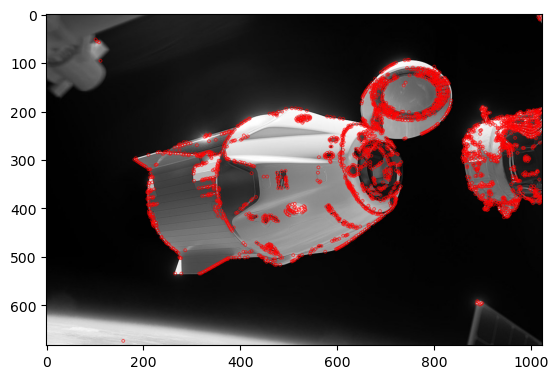

In [74]:
crew_d = cv2.imread("Crew_Dragon.jpg", cv2.IMREAD_GRAYSCALE)
capsule = cv2.imread("capsule.jpg", cv2.IMREAD_GRAYSCALE)

fast = cv2.FastFeatureDetector_create(threshold=20)

kp_cd = fast.detect(crew_d,None)
img2 = cv2.drawKeypoints(crew_d, kp_cd, None,color=(255,0,0))
plt.imshow(img2)

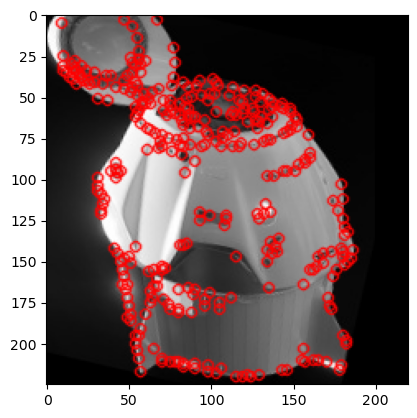

In [75]:
fast = cv2.FastFeatureDetector_create(threshold=20)

kp_c = fast.detect(capsule,None)
img2 = cv2.drawKeypoints(capsule, kp_c, None,color=(255,0,0))
plt.imshow(img2)

### 5. Binary Robust Independent Elementary Features (BRIEF)

BRIEF calcule des descripteurs pour chaque point d'intérêt. Tout d'abord, un flou est effectué sur l'image d'entrée pour diminuer le niveau de bruit. Il est possible d'utiliser un flou tel que codé précédemment avec les fonctions moyenne_voisins ou convolution, ou alors d'utiliser un flou gaussien à l'aide des deux lignes suivantes (si supporté par l'installation Python du CREMI...) :
> from scipy.ndimage import gaussian_filter
> 
> gaussian_filter(img, sigma=2)

On cherche alors à obtenir un descripteur, ici un vecteur de taille 128, pour chaque pixel détecté comme un point d'intérêt par FAST. On considère le voisinage de ce pixel (carré de taille 9x9). Dans ce voisinage, 128 paires de pixels (A,B) sont sélectionnées aléatoirement. Pour chacune de ces paires, si img(A) < img(B), alors le vecteur prend la valeur 1 (dans la case correspondant au numéro de la paire considérée). Dans le cas contraire, le vecteur prend la valeur 0.

### 6. Oriented FAST and Rotated BRIEF (ORB)
ORB combine le détecteur de points d'intérêt FAST et le descripteur binaire BRIEF en une seule méthode de détection et de description de caractéristiques.
- Calcul d'orientation pour chaque point d'intérêt (en détectant les coins et le centroïde)
- Mécanisme d'invariance à l'échelle en calculant les descripteurs à plusieurs résolutions 

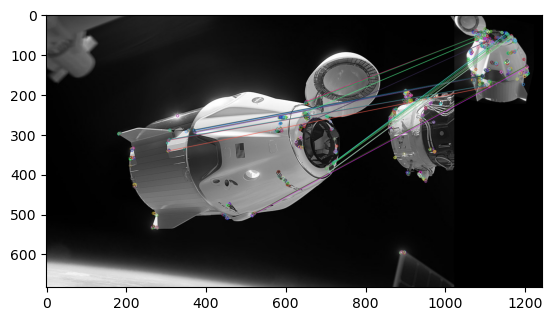

In [76]:
orb = cv2.ORB_create()

keypoints1, descriptors1 = orb.detectAndCompute(crew_d, None)
keypoints2, descriptors2 = orb.detectAndCompute(capsule, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = bf.match(descriptors1, descriptors2)

matches = sorted(matches, key=lambda x: x.distance)

# Draw the first 10 matches
result_image = cv2.drawMatches(crew_d, keypoints1, capsule, keypoints2, matches[:20], outImg=None)

plt.imshow(result_image)
